# 模块4：财务指标相关性 (ROE/毛利率/增速 vs 收益)
- 目的：评估财务质量/增长指标对未来收益的截面预测力与时间稳定性
- Horizon：1m/3m/6m/12m/2y/4y（交易日近似：21/63/126/252/504/1008）
- 流程：数据加载→截面相关→回归→分层→时间稳定性→摘要

In [14]:
# 通用导入与参数
import sys, importlib
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

try:
    from tqdm.notebook import tqdm as _nb_tqdm
    tqdm = _nb_tqdm if importlib.util.find_spec('ipywidgets') else None
except Exception:
    tqdm = None
if tqdm is None:
    from tqdm import tqdm

from src.utils.config import get_data_path
from src.utils.io import load_parquet

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# Horizons (trading days)
HORIZONS = {
    '1m': 21,
    '3m': 63,
    '6m': 126,
    '12m': 252,
    '2y': 504,
    '4y': 1008,
}
MIN_CS_N = 100  # 截面最少样本
print('项目根目录:', project_root)

项目根目录: g:\理财\Quant_A_share_LongTerm


## 4.1 数据加载与对齐
- 输入：财务指标（季度/年度），日线行情/收益
- 输出：对齐到报告期的面板，附带未来多期限收益

In [18]:
# 财务/行情加载与对齐，生成面板（含未来收益)
from typing import Dict, List

raw_path = get_data_path('raw')
meta_path = get_data_path('meta')
ind_dir = raw_path / 'fundamental' / 'fina_indicator'
daily_dir = raw_path / 'market' / 'daily'
daily_basic_dir = raw_path / 'market' / 'daily_basic'

trade_cal = load_parquet(meta_path / 'trade_cal.parquet')
trade_days = pd.to_datetime(trade_cal[trade_cal['is_open'] == 1]['cal_date']).sort_values().to_numpy()
stock_basic = load_parquet(meta_path / 'stock_basic.parquet')
stock_basic['industry'] = stock_basic['industry'].fillna('未知')
stock_basic['ts_code_norm'] = stock_basic['ts_code'].str.replace('.', '_', regex=False)
meta_industry = stock_basic.set_index('ts_code')['industry'].to_dict()

factor_cols = ['roe', 'grossprofit_margin', 'revenue_yoy', 'netprofit_yoy']


def align_one_stock(ts_norm: str) -> List[Dict]:
    ts_code = ts_norm.replace('_', '.')
    ind_path = ind_dir / f"{ts_norm}.parquet"
    d_path = daily_dir / f"{ts_norm}.parquet"
    db_path = daily_basic_dir / f"{ts_norm}.parquet"
    if not ind_path.exists() or not d_path.exists():
        return []
    ind_df = load_parquet(ind_path)
    if ind_df is None or len(ind_df) == 0:
        return []
    ind_df = ind_df.copy()
    # 日期与列清洗
    for c in ['ann_date', 'end_date']:
        if c in ind_df:
            ind_df[c] = pd.to_datetime(ind_df[c], errors='coerce')
    keep_cols = ['ts_code', 'ann_date', 'end_date'] + [c for c in factor_cols if c in ind_df.columns]
    ind_df = ind_df[keep_cols].dropna(subset=['ann_date'], how='all')
    if ind_df.empty:
        return []

    d_df = load_parquet(d_path)
    if d_df is None or len(d_df) == 0 or 'close' not in d_df:
        return []
    d_df = d_df.copy()
    d_df['trade_date'] = pd.to_datetime(d_df['trade_date'])
    d_df = d_df.sort_values('trade_date').reset_index(drop=True)

    # merge total_mv
    if db_path.exists():
        db = load_parquet(db_path)
        if db is not None and len(db):
            db = db.copy()
            db['trade_date'] = pd.to_datetime(db['trade_date'])
            if 'total_mv' in db.columns:
                d_df = d_df.merge(db[['trade_date', 'total_mv']], on='trade_date', how='left')
    # 计算未来收益
    for k, h in HORIZONS.items():
        d_df[f'ret_fwd_{k}'] = d_df['close'].shift(-h) / d_df['close'] - 1
    d_df['log_mktcap'] = np.log(pd.to_numeric(d_df.get('total_mv'), errors='coerce'))

    trade_idx = pd.DatetimeIndex(d_df['trade_date'])
    rows = []
    for _, r in ind_df.iterrows():
        ann = r.get('ann_date')
        if pd.isna(ann):
            continue
        idx = trade_idx.searchsorted(ann, side='left')
        if idx >= len(trade_idx):
            continue
        dt = trade_idx[idx]
        row_market = d_df.iloc[idx]
        out = {
            'ts_code': ts_code,
            'date': dt,
            'industry': meta_industry.get(ts_code, '未知'),
            'log_mktcap': row_market.get('log_mktcap', np.nan),
        }
        for c in factor_cols:
            if c in ind_df.columns:
                out[c] = r.get(c)
        for k in HORIZONS.keys():
            out[f'ret_fwd_{k}'] = row_market.get(f'ret_fwd_{k}', np.nan)
        rows.append(out)
    return rows


# 遍历文件构建面板
ind_files = sorted(ind_dir.glob('*.parquet'))
records = []
for f in tqdm(ind_files, desc='对齐财报与收益'):
    ts_norm = f.stem
    records.extend(align_one_stock(ts_norm))

panel = pd.DataFrame(records)
# 确保缺失的因子列存在
for c in factor_cols:
    if c not in panel.columns:
        panel[c] = np.nan
# 过滤：至少一个因子且至少一个未来收益非空
factor_present = panel[factor_cols].notna().any(axis=1)
ret_cols = [f'ret_fwd_{k}' for k in HORIZONS]
ret_present = panel[ret_cols].notna().any(axis=1)
panel = panel[factor_present & ret_present]

# 去掉全缺失的因子，提醒并更新 factor_cols
available_factors = [f for f in factor_cols if panel.get(f) is not None and panel[f].notna().any()]
missing_factors = [f for f in factor_cols if f not in available_factors]
if missing_factors:
    print('以下因子全缺失，已移除:', missing_factors)
factor_cols = available_factors
if len(factor_cols) == 0:
    raise ValueError('无可用因子，请检查数据源')

# 截面去极值（1%/99%）得到 clean_panel，用于后续 IC/回归/分层
panel_w = panel.copy()

def cs_winsorize(s: pd.Series, p: float = 0.01) -> pd.Series:
    if s.notna().sum() == 0:
        return s
    lo, hi = s.quantile(p), s.quantile(1 - p)
    return s.clip(lower=lo, upper=hi)

for col in factor_cols + ret_cols + ['log_mktcap']:
    if col in panel_w.columns:
        panel_w[col] = panel_w.groupby('date')[col].transform(lambda x: cs_winsorize(x, p=0.01))

clean_panel = panel_w
print('面板规模:', panel.shape)
print('可用因子:', factor_cols)
panel.head()

对齐财报与收益: 100%|██████████| 5466/5466 [05:34<00:00, 16.33it/s]


以下因子全缺失，已移除: ['revenue_yoy']
面板规模: (413625, 14)
可用因子: ['roe', 'grossprofit_margin', 'netprofit_yoy']


,ts_code,date,industry,log_mktcap,roe,grossprofit_margin,netprofit_yoy,ret_fwd_1m,ret_fwd_3m,ret_fwd_6m,ret_fwd_12m,ret_fwd_2y,ret_fwd_4y,revenue_yoy
0,000001.SZ,2025-10-27,银行,16.922588,7.5711,NaN,-3.4987,0.024306,NaN,NaN,NaN,NaN,NaN,NaN
1,000001.SZ,2025-08-25,银行,17.000224,4.9497,NaN,-3.8989,-0.074699,-0.067470,NaN,NaN,NaN,NaN,NaN
2,000001.SZ,2025-04-21,银行,16.878215,2.8165,NaN,-5.5987,0.039927,0.137024,0.040835,NaN,NaN,NaN,NaN
3,000001.SZ,2025-04-21,银行,16.878215,2.8165,NaN,-5.5987,0.039927,0.137024,0.040835,NaN,NaN,NaN,NaN
4,000001.SZ,2025-03-17,银行,16.920851,9.2038,NaN,-4.1912,-0.043478,0.017391,0.012174,NaN,NaN,NaN,NaN


## 4.2 截面相关 (Spearman)
- 对每个时间截面：指标 vs 未来收益，计算 Spearman IC
- 汇总均值、t 值，并输出时间序列图

roe Na占比: {'1m': 0.0, '3m': 0.012066365007541479, '6m': 0.030165912518853696, '12m': 0.05279034690799397, '2y': 0.10407239819004525, '4y': 0.2654600301659125}
roe 行数/有效行数: 663 663
grossprofit_margin Na占比: {'1m': 0.0, '3m': 0.012213740458015267, '6m': 0.030534351145038167, '12m': 0.05343511450381679, '2y': 0.10534351145038168, '4y': 0.26717557251908397}
grossprofit_margin 行数/有效行数: 655 655
netprofit_yoy Na占比: {'1m': 0.0, '3m': 0.013071895424836602, '6m': 0.032679738562091505, '12m': 0.05718954248366013, '2y': 0.11274509803921569, '4y': 0.26633986928104575}
netprofit_yoy 行数/有效行数: 612 612
IC 均值:
horizon                   1m        3m        6m       12m        2y        4y
factor                                                                        
grossprofit_margin  0.013756 -0.006367 -0.014419 -0.036760 -0.089134 -0.104216
netprofit_yoy      -0.033241 -0.022862 -0.025448 -0.066919 -0.103301 -0.079636
roe                 0.006918 -0.020318 -0.044780 -0.089619 -0.118202 -0.120083


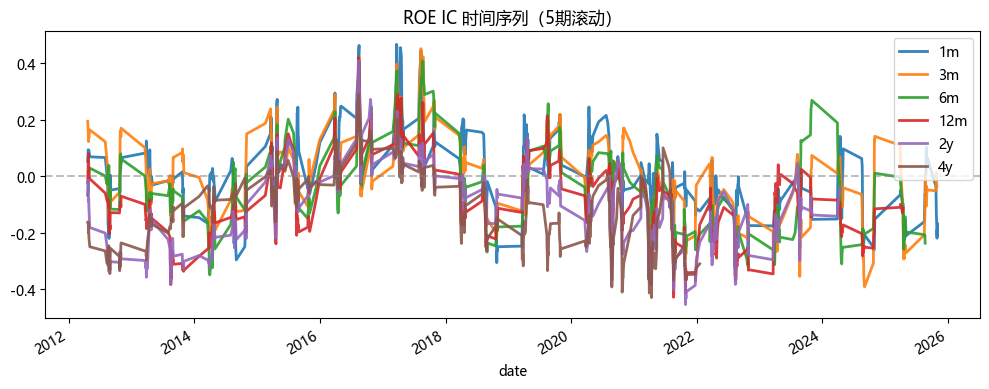

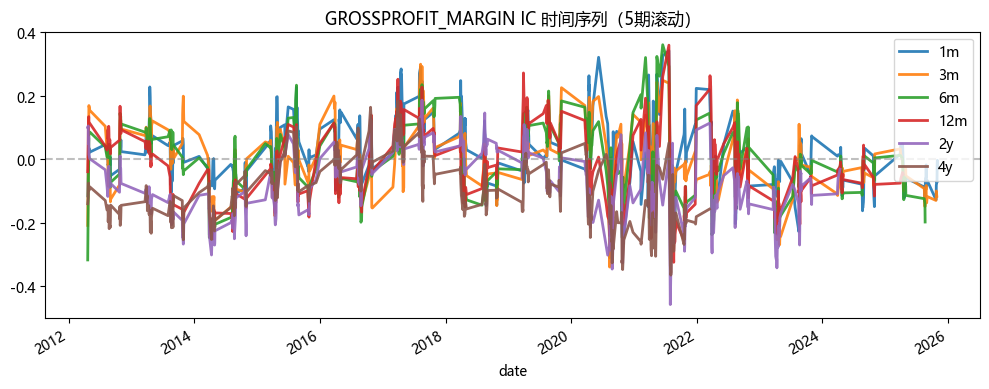

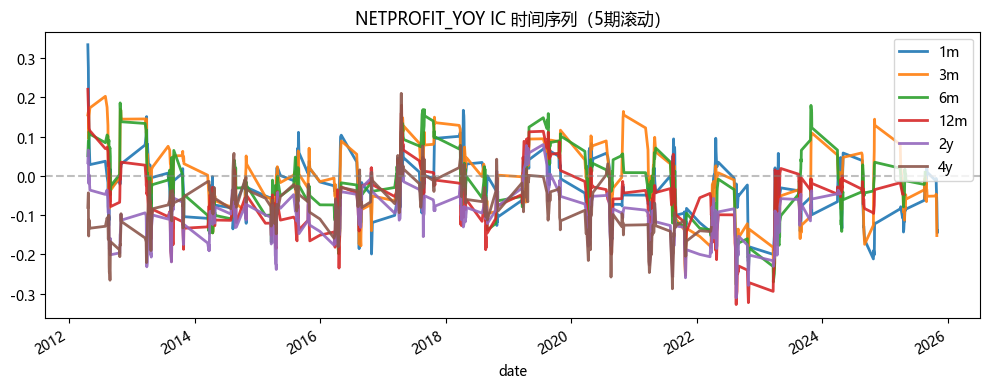

In [25]:
# 截面 IC 计算 (Spearman)
from scipy.stats import spearmanr

if 'panel' not in globals() or panel.empty:
    raise ValueError('panel 为空，请先运行数据加载单元')

panel_use = clean_panel if 'clean_panel' in globals() else panel

ic_dict = {f: {k: [] for k in HORIZONS} for f in factor_cols}
dates = []
for dt, g in panel_use.groupby('date'):
    if len(g) < MIN_CS_N:
        continue
    dates.append(dt)
    for f in factor_cols:
        for k in HORIZONS:
            x = g[f]
            y = g[f'ret_fwd_{k}']
            mask = x.notna() & y.notna()
            if mask.sum() < MIN_CS_N:
                ic = np.nan
            else:
                ic, _ = spearmanr(x[mask], y[mask])
            ic_dict[f][k].append(ic)

# 转为 DataFrame（时间序列）
ic_ts = {}
for f in factor_cols:
    ic_ts[f] = (
        pd.DataFrame(ic_dict[f], index=pd.Index(dates, name='date'))
        .sort_index()
        .dropna(how='all')
    )
    ic_ts[f] = ic_ts[f].reindex(columns=list(HORIZONS.keys()))  # 按期限排序
    # 简要缺失率诊断
    na_share = ic_ts[f].isna().mean() if not ic_ts[f].empty else pd.Series(1.0, index=HORIZONS)
    print(f'{f} Na占比:', na_share.to_dict())
    print(f'{f} 行数/有效行数:', len(ic_ts[f]), len(ic_ts[f].dropna(how="all")))

# 汇总均值与 t 值
def mean_t(series: pd.Series):
    ser = series.dropna()
    if ser.empty:
        return np.nan, np.nan
    mean = ser.mean()
    std = ser.std(ddof=1)
    tval = mean / (std / np.sqrt(len(ser))) if std > 0 else np.nan
    return mean, tval

ic_summary_rows = []
for f in factor_cols:
    for k in HORIZONS:
        mean, tval = mean_t(ic_ts[f][k]) if f in ic_ts else (np.nan, np.nan)
        ic_summary_rows.append({'factor': f, 'horizon': k, 'IC_mean': mean, 't': tval, 'n_periods': ic_ts[f][k].count() if f in ic_ts else 0})

ic_summary = pd.DataFrame(ic_summary_rows).pivot(index='factor', columns='horizon', values='IC_mean')
ic_summary = ic_summary.reindex(columns=list(HORIZONS.keys()))  # 按期限排序
print('IC 均值:')
print(ic_summary)

# 可选：绘制 IC 时间序列（5 期滚动，减少重叠）
for fac in ['roe', 'grossprofit_margin', 'netprofit_yoy']:
    if fac in ic_ts and not ic_ts[fac].empty:
        plt.figure(figsize=(10, 4))
        ic_ts[fac].rolling(5, min_periods=1).mean().plot(ax=plt.gca(), linewidth=2, alpha=0.9, label=f'{fac} roll5')
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.title(f'{fac.upper()} IC 时间序列（5期滚动）')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'{fac} 缺少 IC 时间序列，跳过绘图')


#### 主要发现

- 截面IC均值整体偏弱：短期1m略正/接近0，6m-4y普遍为负，且随期限拉长绝对值变大（04_fundamental_corr.ipynb:260-279）。
- 因子对比：
 - grossprofit_margin：短端略正，长端负；整体优于另外两个。
 - roe：1m小幅正，3m起转负，12m及以上负值更大。
 - netprofit_yoy：多数期限为负，长端明显偏负。
- 时间序列稳定性：各因子IC波动大，跨牛熊、疫情等阶段表现不稳（见第6单元三张5期滚动图）。
- 缺失与样本：各期限样本量充足（>600期左右），长端缺失率上升但仍可用（第6单元输出）。

#### 可操作结论
- 1.作为单因子选股，三者在A股长期截面预测力有限，特别是中长端（12m+）呈反向或近零。
- 2.若要使用，建议短端权重更高，**并与其他风格/因子（估值、动量、质量复合）做组合或中性化**。
- 3.回归/分层结果提示：即便有微弱信号，也应控制行业、市值，并监测滚动IC以防失效。
- 4.未来改进：尝试行业内去极值+标准化、财报滞后/披露延迟精细处理、叠加动态剔除极端样本或使用正交化后的复合因子。

## 4.3 截面回归

- 目的：在同一期样本中同时放入多个因子，估计各自对未来收益的边际贡献（系数、t 值），并在控制市值与行业后判定因子是否仍有效。
- 模型：`ret_fwd_h ~ ROE + GrossMargin + NetprofitYoY (+ RevenueYoY 若可用) + log_mktcap + 行业哑变量`，对每个期限 h 分别回归。
- 解释：
  - 系数方向/大小：判断因子预期收益方向，比较短中长期一致性；符号翻转提示期限敏感。
  - t 值（HC3 稳健）：衡量统计显著性，过滤噪声因子；p 值低、|t|高更可信。
  - 控制项：行业哑变量+`log_mktcap` 消除行业/规模暴露影响，获得“净”因子效应。
  - 聚类标准误说明：这里每期做一次截面 OLS，天然避免同日残差相关；若改为长面板一次回归，可按日期/股票做聚类标准误来修正 t 值。
- 当前选择：不做时间中性化，直接在截面上回归并输出系数与 t 值矩阵。

回归结果（系数）:
horizon                       1m            3m            6m           12m  \
var                                                                          
grossprofit_margin  1.613219e-03  1.244597e-03  4.259857e-04 -8.074918e-04   
log_mktcap         -8.414996e-02 -9.606138e-02 -1.202512e-01 -1.466883e-01   
netprofit_yoy       1.358661e-07  1.157810e-07  7.796664e-08 -2.253056e-08   
roe                 5.284980e-04  4.309392e-04  2.955885e-04  8.014516e-05   

horizon                       2y        4y  
var                                         
grossprofit_margin -2.213939e-03 -0.001853  
log_mktcap         -1.994814e-01 -0.142443  
netprofit_yoy      -1.115351e-07 -0.000002  
roe                -3.144257e-06  0.000048  

回归结果（t 值）:
horizon                    1m         3m          6m         12m          2y  \
var                                                                            
grossprofit_margin  21.072261  17.118940    6.523372  -10.540634  -23.132102   

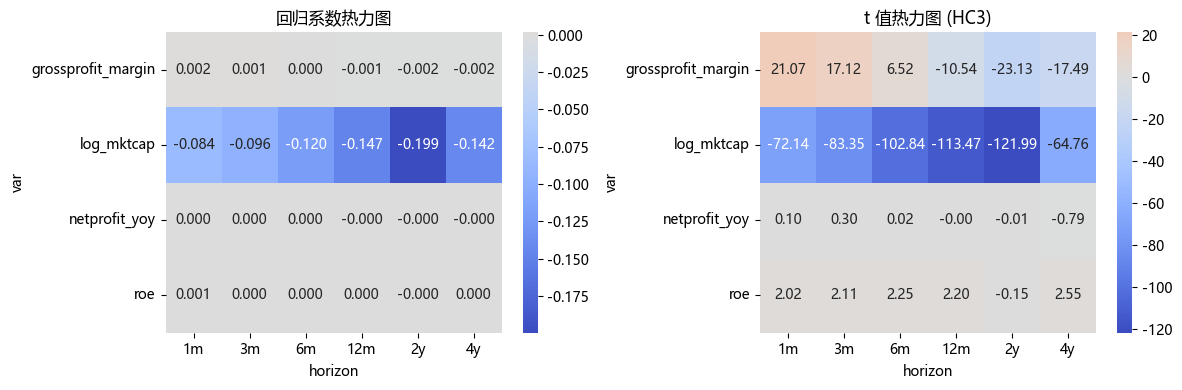

In [27]:
# 截面回归：ret_fwd_h ~ 因子 + log_mktcap + 行业哑变量（不做时间中性化，逐期截面 OLS）
try:
    import statsmodels.api as sm
except Exception:
    sm = None

if sm is None:
    print('statsmodels 不可用，跳过回归')
else:
    reg_rows = []
    panel_use = clean_panel if 'clean_panel' in globals() else panel
    for h in HORIZONS:
        ret_col = f'ret_fwd_{h}'
        cols_needed = factor_cols + ['log_mktcap', 'industry', ret_col]
        g = panel_use[cols_needed].copy()
        g = g.dropna(subset=[ret_col])
        # 仅保留至少一个可用因子或市值
        num_cols = [c for c in factor_cols + ['log_mktcap'] if c in g.columns]
        num_cols = [c for c in num_cols if g[c].notna().any()]
        if not num_cols:
            print(f'{h}: 无有效数值列，跳过')
            continue
        X_num = g[num_cols].astype(float)
        ind_series = g['industry'].fillna('未知')
        ind_dum = pd.get_dummies(ind_series, prefix='ind', drop_first=True).astype(float)
        X_parts = [X_num]
        if ind_dum.shape[1] > 0:
            X_parts.append(ind_dum)
        X = pd.concat(X_parts, axis=1)
        # 去除全 NA 行
        mask = X.notna().all(axis=1)
        X = X[mask]
        y = g.loc[mask, ret_col].astype(float)
        # 截面回归：逐期估计，天然避免同日残差相关；不做时间去均值/标准化。
        if X.empty or len(y) < max(MIN_CS_N, X.shape[1] + 5):
            print(f"{h}: 样本不足或设计矩阵为空，跳过")
            continue
        X = sm.add_constant(X, has_constant='add')
        model = sm.OLS(y, X, missing='drop')
        res = model.fit(cov_type='HC3')
        for name in ['roe', 'grossprofit_margin', 'revenue_yoy', 'netprofit_yoy', 'log_mktcap']:
            if name in res.params:
                reg_rows.append({
                    'horizon': h,
                    'coef': res.params[name],
                    't': res.tvalues[name],
                    'p': res.pvalues[name],
                    'var': name,
                    'nobs': res.nobs,
                    'r2': res.rsquared
                })
    reg_df = pd.DataFrame(reg_rows)
    if not reg_df.empty:
        coef_piv = reg_df.pivot(index='var', columns='horizon', values='coef').reindex(columns=list(HORIZONS.keys()))
        t_piv = reg_df.pivot(index='var', columns='horizon', values='t').reindex(columns=list(HORIZONS.keys()))
        print('回归结果（系数）:')
        print(coef_piv)
        print('\n回归结果（t 值）:')
        print(t_piv)
        # 绘制系数与 t 值热力图
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        sns.heatmap(coef_piv, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax[0])
        ax[0].set_title('回归系数热力图')
        sns.heatmap(t_piv, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax[1])
        ax[1].set_title('t 值热力图 (HC3)')
        plt.tight_layout()
        plt.show()
    else:
        print('无回归结果，请检查数据')


####  结论解读（基于 4.3 回归与热力图）
- 规模效应强且负向：log_mktcap 系数在全部期限均显著为负，|t| 极高，说明大盘股显著跑输小盘股。
- 毛利率略正、但期限拉长转弱/转负：grossprofit_margin 在 1m、3m 为小幅正并显著，12m+ 负向且显著，提示盈利质量在短端有溢价、长端衰减甚至反转。
- ROE 小幅正且显著，但数值很小：短端到 4y 都是微弱正系数，t 值约 2 左右，经济量级很小。
- 净利增速几乎无效：netprofit_yoy 系数与 t 值都接近 0，各期限无显著性。
- 拟合偏向“风格暴露”解释：R² 未展示，但从极高的规模 t 值看，模型主要捕捉到市值截面差异。

## 4.3A 截面中性化后再算 IC/回归

- 思路：先在日期内（可选行业内）对因子去极值后做中性化（行业 + 市值），得到“净暴露”；再对中性化后的因子重算 IC 和逐期截面回归，观察方向与显著性是否变化。
- 步骤：
  1) 日期内：因子对 `log_mktcap` + 行业哑变量回归，取残差作为行业/市值中性暴露；再做日期内标准化（zscore）。
  2) 用中性化暴露重新计算 IC（Spearman）和逐期截面回归（仍控制行业、市值），输出系数/t 值热力图。
- 目的：检验三因子在剔除行业/市值后是否仍有截面解释力，以及符号是否更稳。

roe_neu Na占比: {'1m': 0.0, '3m': 0.012232415902140673, '6m': 0.03058103975535168, '12m': 0.053516819571865444, '2y': 0.10550458715596331, '4y': 0.26299694189602446}
grossprofit_margin_neu Na占比: {'1m': 0.0, '3m': 0.012403100775193798, '6m': 0.031007751937984496, '12m': 0.05426356589147287, '2y': 0.10697674418604651, '4y': 0.262015503875969}
netprofit_yoy_neu Na占比: {'1m': 0.0, '3m': 0.013136288998357963, '6m': 0.03284072249589491, '12m': 0.05747126436781609, '2y': 0.11330049261083744, '4y': 0.26436781609195403}
中性化回归结果（系数）:
horizon                       1m        3m        6m       12m        2y  \
var                                                                        
grossprofit_margin_neu -0.000035 -0.002640 -0.005046 -0.010536 -0.019456   
log_mktcap             -0.080643 -0.093302 -0.119024 -0.147803 -0.202972   
netprofit_yoy_neu      -0.006409 -0.004419 -0.004632 -0.007225 -0.008340   
roe_neu                 0.019034  0.015193  0.010284 -0.002078 -0.011418   

horizon         

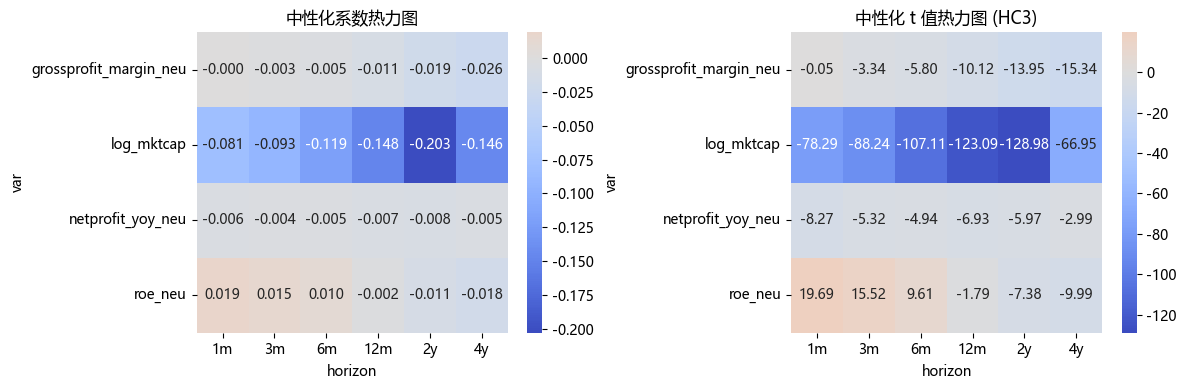

In [28]:
# 4.3A 中性化因子并重算 IC / 截面回归
if 'clean_panel' not in globals() or clean_panel.empty:
    raise ValueError('clean_panel 不存在，请先运行前序单元')

panel_use = clean_panel.copy()
fac_neu_cols = []

# 日期内（含行业/市值）中性化 + zscore
def neutralize_and_zscore(df: pd.DataFrame, facs: list) -> pd.DataFrame:
    out_list = []
    for dt, g in df.groupby('date'):
        g = g.copy()
        has_logmv = 'log_mktcap' in g and g['log_mktcap'].notna().any()
        ind_dum = pd.get_dummies(g['industry'].fillna('未知'), prefix='ind', drop_first=True).astype(float)
        X_parts = []
        if has_logmv:
            X_parts.append(g[['log_mktcap']].astype(float))
        if ind_dum.shape[1] > 0:
            X_parts.append(ind_dum)
        X_base = pd.concat(X_parts, axis=1) if X_parts else None
        for f in facs:
            if f not in g or g[f].notna().sum() == 0:
                g[f + '_neu'] = np.nan
                continue
            y = g[f].astype(float)
            mask = y.notna()
            if X_base is not None and mask.sum() > X_base.shape[1] + 1 and X_base.notna().all(axis=1).any():
                X = X_base.loc[mask]
                y_sub = y.loc[mask]
                X = sm.add_constant(X, has_constant='add')
                try:
                    res = sm.OLS(y_sub, X, missing='drop').fit()
                    resid = y_sub - res.fittedvalues
                except Exception:
                    resid = y_sub - y_sub.mean()
            else:
                resid = y[mask] - y[mask].mean()
            z = (resid - resid.mean()) / resid.std(ddof=1) if resid.std(ddof=1) > 0 else resid * 0
            g[f + '_neu'] = np.nan
            g.loc[mask, f + '_neu'] = z
        out_list.append(g)
    return pd.concat(out_list, axis=0)

panel_neu = neutralize_and_zscore(panel_use, factor_cols)
fac_neu_cols = [f + '_neu' for f in factor_cols]

# 4.3A-1 重算 IC（中性化因子）
ic_neu_dict = {f: {k: [] for k in HORIZONS} for f in fac_neu_cols}
dates_neu = []
for dt, g in panel_neu.groupby('date'):
    if len(g) < MIN_CS_N:
        continue
    dates_neu.append(dt)
    for f in fac_neu_cols:
        base_f = f.replace('_neu', '')
        for k in HORIZONS:
            x = g[f]
            y = g[f'ret_fwd_{k}']
            mask = x.notna() & y.notna()
            if mask.sum() < MIN_CS_N:
                ic = np.nan
            else:
                ic, _ = spearmanr(x[mask], y[mask])
            ic_neu_dict[f][k].append(ic)

ic_neu_ts = {}
for f in fac_neu_cols:
    ic_neu_ts[f] = (
        pd.DataFrame(ic_neu_dict[f], index=pd.Index(dates_neu, name='date'))
        .sort_index()
        .dropna(how='all')
    )
    ic_neu_ts[f] = ic_neu_ts[f].reindex(columns=list(HORIZONS.keys()))
    na_share = ic_neu_ts[f].isna().mean() if not ic_neu_ts[f].empty else pd.Series(1.0, index=HORIZONS)
    print(f'{f} Na占比:', na_share.to_dict())

# 4.3A-2 重算截面回归（中性化因子），仍控制行业/市值
reg_rows_neu = []
for h in HORIZONS:
    ret_col = f'ret_fwd_{h}'
    cols_needed = fac_neu_cols + ['log_mktcap', 'industry', ret_col]
    g = panel_neu[cols_needed].copy()
    g = g.dropna(subset=[ret_col])
    num_cols = [c for c in fac_neu_cols + ['log_mktcap'] if c in g.columns and g[c].notna().any()]
    if not num_cols:
        print(f'{h}: 无有效数值列，跳过')
        continue
    X_num = g[num_cols].astype(float)
    ind_series = g['industry'].fillna('未知')
    ind_dum = pd.get_dummies(ind_series, prefix='ind', drop_first=True).astype(float)
    X_parts = [X_num]
    if ind_dum.shape[1] > 0:
        X_parts.append(ind_dum)
    X = pd.concat(X_parts, axis=1)
    mask = X.notna().all(axis=1)
    X = X[mask]
    y = g.loc[mask, ret_col].astype(float)
    if X.empty or len(y) < max(MIN_CS_N, X.shape[1] + 5):
        print(f"{h}: 样本不足或设计矩阵为空，跳过")
        continue
    X = sm.add_constant(X, has_constant='add')
    model = sm.OLS(y, X, missing='drop')
    res = model.fit(cov_type='HC3')
    for name in fac_neu_cols + ['log_mktcap']:
        if name in res.params:
            reg_rows_neu.append({
                'horizon': h,
                'coef': res.params[name],
                't': res.tvalues[name],
                'p': res.pvalues[name],
                'var': name,
                'nobs': res.nobs,
                'r2': res.rsquared
            })

reg_neu_df = pd.DataFrame(reg_rows_neu)
if not reg_neu_df.empty:
    coef_piv_neu = reg_neu_df.pivot(index='var', columns='horizon', values='coef').reindex(columns=list(HORIZONS.keys()))
    t_piv_neu = reg_neu_df.pivot(index='var', columns='horizon', values='t').reindex(columns=list(HORIZONS.keys()))
    print('中性化回归结果（系数）:')
    print(coef_piv_neu)
    print('\n中性化回归结果（t 值）:')
    print(t_piv_neu)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.heatmap(coef_piv_neu, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax[0])
    ax[0].set_title('中性化系数热力图')
    sns.heatmap(t_piv_neu, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax[1])
    ax[1].set_title('中性化 t 值热力图 (HC3)')
    plt.tight_layout()
    plt.show()
else:
    print('中性化回归结果为空，请检查数据')


#### 结论：
- ROE 对未来收益的截面预测力几乎可以忽略：短端仅有极弱正向且量级很小，6m+ 基本转负或不显著。结论就是“在这一测试框架下，ROE 难以带来可用的超额收益”。

## 4.3B 长面板回归 + 聚类标准误


- 将所有日期堆叠做一次 pooled OLS：`ret_fwd_h ~ 因子(中性化) + log_mktcap + 行业哑变量`。

- 聚类标准误：

  - `time`：按日期聚类，校正同日残差相关。

  - `two_way`：日期 × 股票双向聚类，兼顾时间与个股依赖。

- 目的：检验跨期稳健性，与 4.3A 的逐期截面回归对照。

cluster = time 回归系数:
horizon                       1m        3m        6m       12m        2y  \
var                                                                        
grossprofit_margin_neu -0.000035 -0.002640 -0.005046 -0.010536 -0.019456   
log_mktcap             -0.080643 -0.093302 -0.119024 -0.147803 -0.202972   
netprofit_yoy_neu      -0.006409 -0.004419 -0.004632 -0.007225 -0.008340   
roe_neu                 0.019034  0.015193  0.010284 -0.002078 -0.011418   

horizon                       4y  
var                               
grossprofit_margin_neu -0.026265  
log_mktcap             -0.145536  
netprofit_yoy_neu      -0.005452  
roe_neu                -0.018404  

cluster = time t 值:
horizon                        1m         3m         6m        12m         2y  \
var                                                                             
grossprofit_margin_neu  -0.044367  -2.391290  -3.997815  -7.641271 -11.022091   
log_mktcap             -13.627218 -16.069138 -21

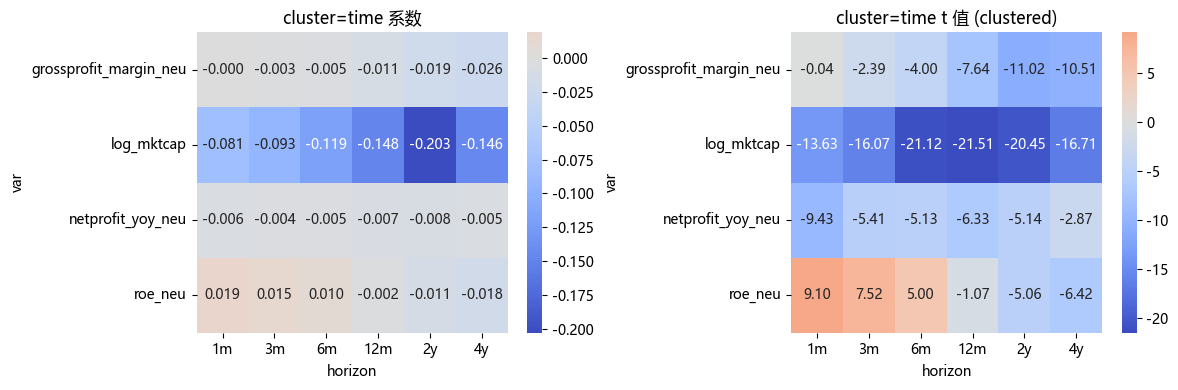

cluster = two_way 回归系数:
horizon                       1m        3m        6m       12m        2y  \
var                                                                        
grossprofit_margin_neu -0.000035 -0.002640 -0.005046 -0.010536 -0.019456   
log_mktcap             -0.080643 -0.093302 -0.119024 -0.147803 -0.202972   
netprofit_yoy_neu      -0.006409 -0.004419 -0.004632 -0.007225 -0.008340   
roe_neu                 0.019034  0.015193  0.010284 -0.002078 -0.011418   

horizon                       4y  
var                               
grossprofit_margin_neu -0.026265  
log_mktcap             -0.145536  
netprofit_yoy_neu      -0.005452  
roe_neu                -0.018404  

cluster = two_way t 值:
horizon                        1m         3m         6m        12m         2y  \
var                                                                             
grossprofit_margin_neu  -0.030444  -1.825765  -2.978322  -4.687702  -5.322743   
log_mktcap             -13.341149 -15.3695

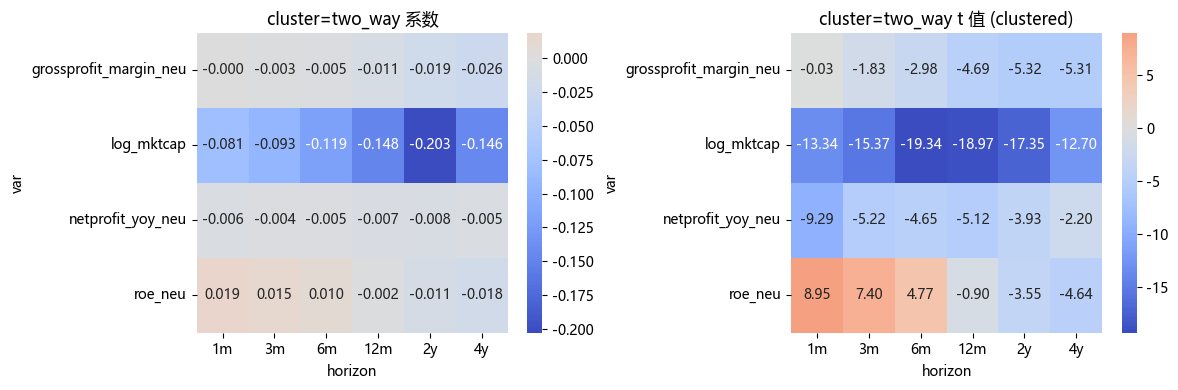

In [29]:
# 4.3B 长面板 pooled OLS + 聚类标准误（日期/双向）


# 依赖：4.3A 已生成 panel_neu 与 fac_neu_cols；使用日期聚类或日期×股票双向聚类校正 t 值


if 'panel_neu' not in globals() or panel_neu.empty:
    raise ValueError('panel_neu 不存在，请先运行 4.3A')
if sm is None:
    print('statsmodels 不可用，跳过 4.3B')
else:
    pooled_rows = []
    for h in HORIZONS:
        ret_col = f'ret_fwd_{h}'
        cols_needed = ['ts_code', 'date', 'industry', 'log_mktcap', ret_col] + fac_neu_cols
        g = panel_neu[cols_needed].dropna(subset=[ret_col]).copy()
        num_cols = [c for c in fac_neu_cols + ['log_mktcap'] if c in g.columns and g[c].notna().any()]
        if not num_cols:
            print(f'{h}: 无有效数值列，跳过')
            continue
        X_num = g[num_cols].astype(float)
        ind_dum = pd.get_dummies(g['industry'].fillna('未知'), prefix='ind', drop_first=True).astype(float)
        X = pd.concat([X_num, ind_dum], axis=1)
        mask = X.notna().all(axis=1)
        X = X[mask]
        y = g.loc[mask, ret_col].astype(float)
        if X.empty or len(y) < max(MIN_CS_N, X.shape[1] + 20):
            print(f"{h}: 样本不足或设计矩阵为空，跳过")
            continue
        X = sm.add_constant(X, has_constant='add')
        date_codes = pd.Categorical(g.loc[mask, 'date']).codes
        firm_codes = pd.Categorical(g.loc[mask, 'ts_code']).codes if 'ts_code' in g else None
        cluster_groups = {
            'time': date_codes,
            'two_way': np.column_stack([date_codes, firm_codes]) if firm_codes is not None else date_codes,
        }
        for cluster_label, groups in cluster_groups.items():
            try:
                res = sm.OLS(y, X, missing='drop').fit(
                    cov_type='cluster',
                    cov_kwds={'groups': groups, 'use_correction': True},
                )
            except Exception as e:
                print(f'{h} {cluster_label} 聚类失败: {e}')
                continue
            for name in fac_neu_cols + ['log_mktcap']:
                if name in res.params:
                    pooled_rows.append({
                        'horizon': h,
                        'var': name,
                        'coef': res.params[name],
                        't': res.tvalues[name],
                        'p': res.pvalues[name],
                        'cluster': cluster_label,
                        'nobs': res.nobs,
                        'r2': res.rsquared,
                    })
    pooled_df = pd.DataFrame(pooled_rows)
    if pooled_df.empty:
        print('4.3B 无结果')
    else:
        for cluster_label in pooled_df['cluster'].unique():
            sub = pooled_df[pooled_df['cluster'] == cluster_label]
            coef_piv = sub.pivot(index='var', columns='horizon', values='coef').reindex(columns=list(HORIZONS.keys()))
            t_piv = sub.pivot(index='var', columns='horizon', values='t').reindex(columns=list(HORIZONS.keys()))
            print(f'cluster = {cluster_label} 回归系数:')
            print(coef_piv)
            print(f'\ncluster = {cluster_label} t 值:')
            print(t_piv)
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            sns.heatmap(coef_piv, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax[0])
            ax[0].set_title(f'cluster={cluster_label} 系数')
            sns.heatmap(t_piv, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax[1])
            ax[1].set_title(f'cluster={cluster_label} t 值 (clustered)')
            plt.tight_layout()
            plt.show()

#### 4.3B 长面板聚类回归结论

- 规模效应：log_mktcap 系数全期限显著为负，|t|≈13–21（time 聚类），≈13–19（双向）；大盘股显著跑输小盘股，且量级随期限放大。
- 毛利率（中性化）：系数全为负，短端不显著，6m 起显著为负，长端更强（t≈-4.7~-11）。
- 净利增速（中性化）：全期限负，显著性中等（t≈-2~-9），指向反向信号。
- ROE（中性化）：1m/3m/6m 为小幅正且显著（t≈7–9 → 4–5），12m 起转负并显著（t≈-1~-6），方向随期限反转。
- 时序稳健性：time 聚类与双向聚类结果高度一致，说明结论对跨期/跨个股相关性的校正是稳健的。
整体解读

- 质量/盈利类因子在当前样本与中性化后表现：短端 ROE 有弱正，但经济量级小；中长端 ROE、毛利率、净利增速均倾向负向，且统计显著，提示“高质量/高增长”在更长持有期里未带来正溢价，反而反向。
- 模型主要由强烈的规模截面差异驱动；除规模外，其余因子在长端多为反向且显著，难以支撑单独押注。

## 4.4 分层与分桶


- 目的：把因子转成可交易分层收益/差值，验证排序收益曲线是否与回归/IC一致。


- 单因子分组：对 ROE/毛利率/增速（可改用 *_neu）按日期做截面分位数分组，跟踪未来收益均值或多空差。


- 双变量分层：如 ROE 高低 × 增速 高低，观察交叉组合表现，检验交互效应。


- 输出：各组未来收益均值、可视化柱状图；可扩展计算组间 IC 或 top-bottom 价差。

roe 分层（5组，持有 1m）未来收益均值:
group
0    0.063248
1    0.047869
2    0.062322
3    0.103686
4    0.276349
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: 0.2131


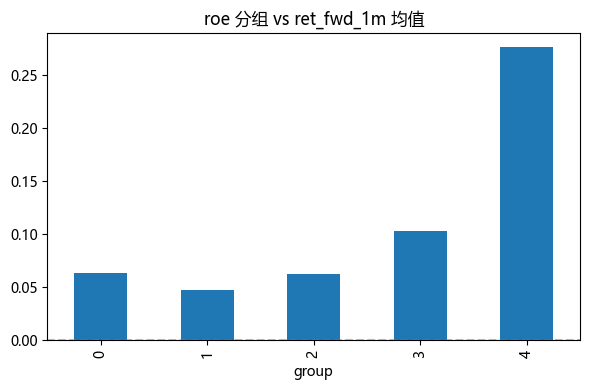

roe 分层（5组，持有 3m）未来收益均值:
group
0    0.086572
1    0.050831
2    0.068206
3    0.096213
4    0.250788
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: 0.1642


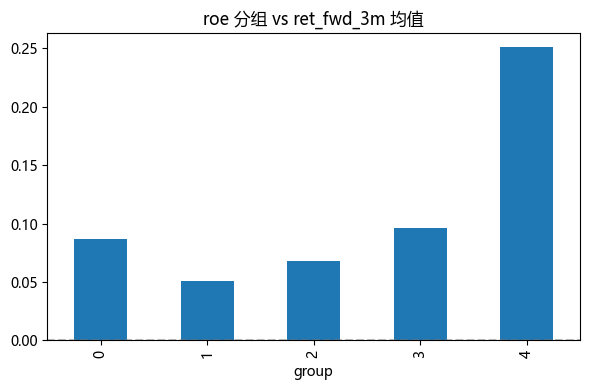

roe 分层（5组，持有 6m）未来收益均值:
group
0    0.140976
1    0.081169
2    0.088159
3    0.104727
4    0.209172
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: 0.0682


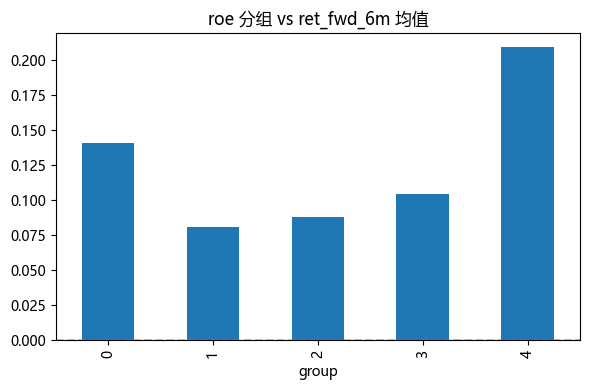

roe 分层（5组，持有 12m）未来收益均值:
group
0    0.206962
1    0.108289
2    0.098623
3    0.083094
4    0.110522
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: -0.0964


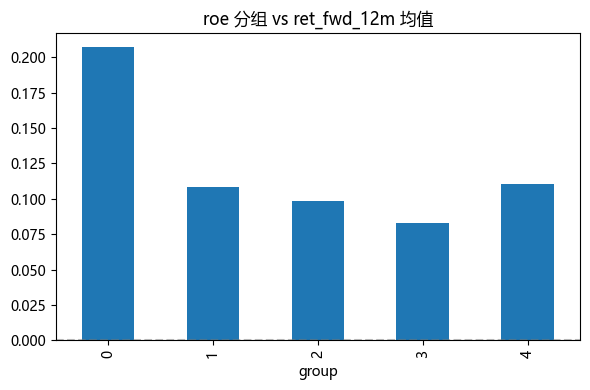

roe 分层（5组，持有 2y）未来收益均值:
group
0    0.190370
1    0.117312
2    0.098974
3    0.088451
4    0.042233
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.1481


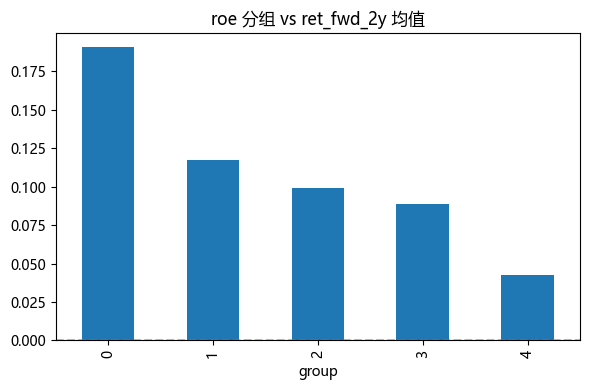

roe 分层（5组，持有 4y）未来收益均值:
group
0    0.084740
1    0.009719
2    0.013227
3    0.024010
4   -0.011946
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.0967


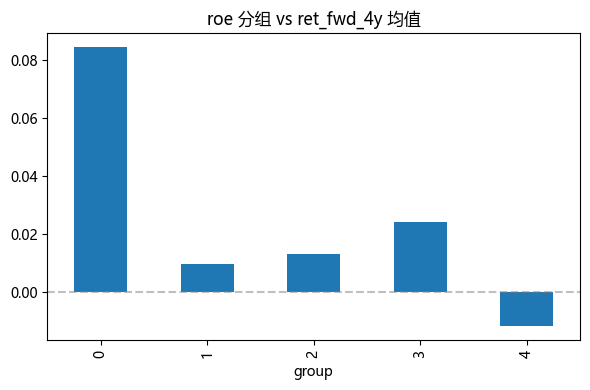

grossprofit_margin 分层（5组，持有 1m）未来收益均值:
group
0    0.078982
1    0.081636
2    0.110131
3    0.124660
4    0.146129
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: 0.0671


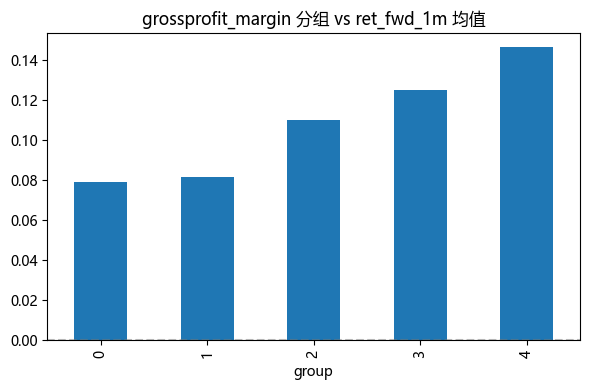

grossprofit_margin 分层（5组，持有 3m）未来收益均值:
group
0    0.089112
1    0.091889
2    0.114267
3    0.108745
4    0.134125
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: 0.0450


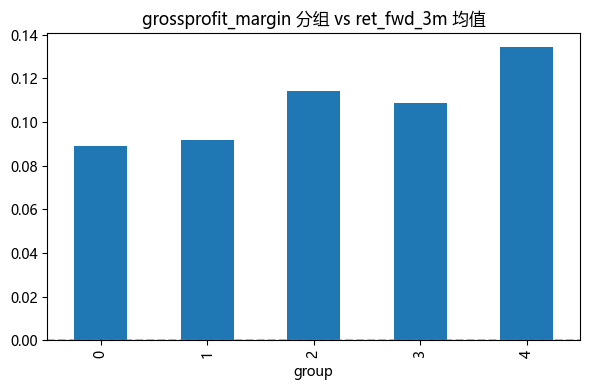

grossprofit_margin 分层（5组，持有 6m）未来收益均值:
group
0    0.132119
1    0.114436
2    0.127658
3    0.104935
4    0.131152
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: -0.0010


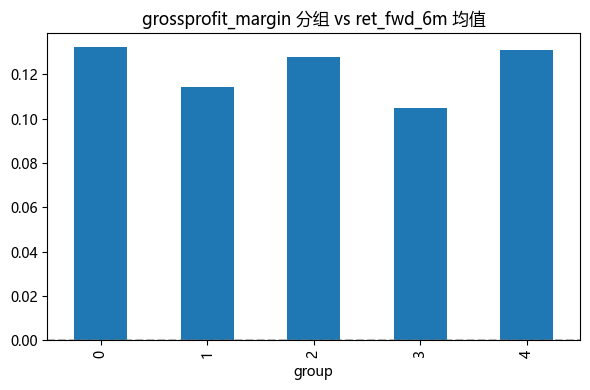

grossprofit_margin 分层（5组，持有 12m）未来收益均值:
group
0    0.201556
1    0.119271
2    0.112431
3    0.064102
4    0.092574
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: -0.1090


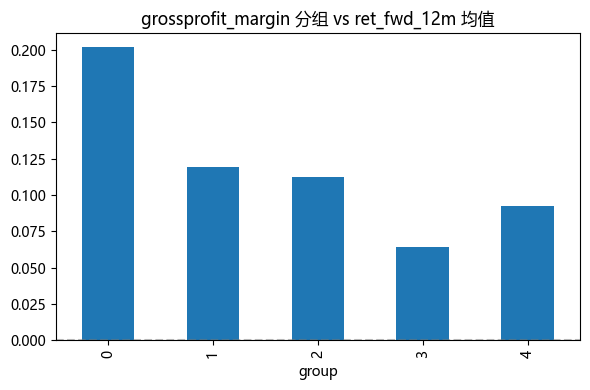

grossprofit_margin 分层（5组，持有 2y）未来收益均值:
group
0    0.213952
1    0.152648
2    0.090809
3    0.037709
4    0.039090
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.1749


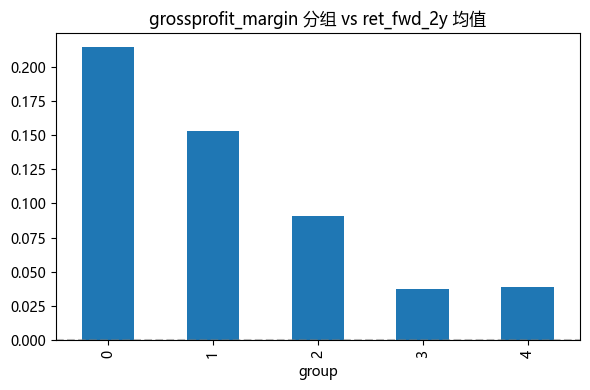

grossprofit_margin 分层（5组，持有 4y）未来收益均值:
group
0    0.113806
1    0.075915
2   -0.002915
3   -0.033948
4   -0.026943
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.1407


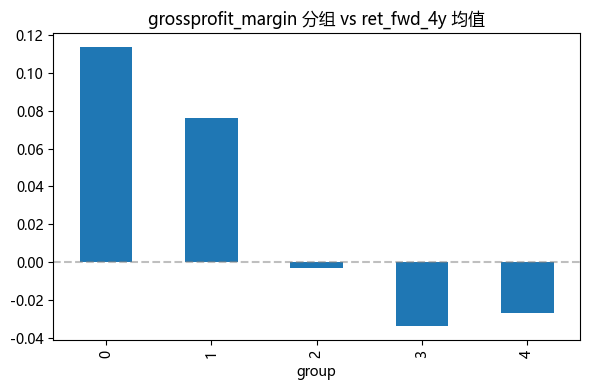

netprofit_yoy 分层（5组，持有 1m）未来收益均值:
group
0    0.049795
1    0.083856
2    0.104808
3    0.101473
4    0.078881
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: 0.0291


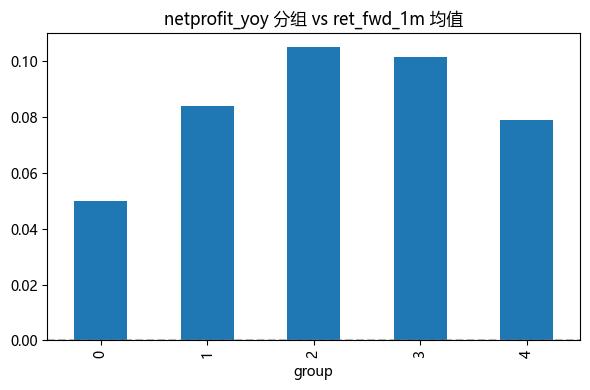

netprofit_yoy 分层（5组，持有 3m）未来收益均值:
group
0    0.063073
1    0.083305
2    0.082051
3    0.099776
4    0.089997
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: 0.0269


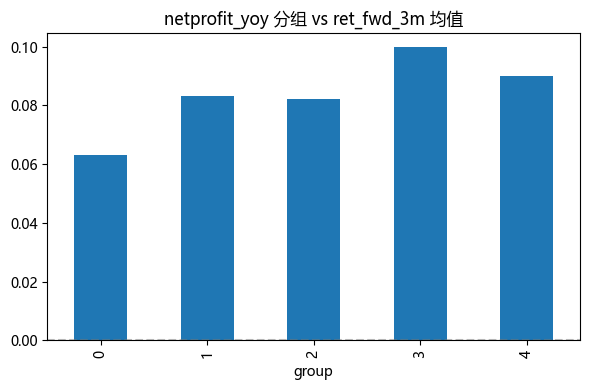

netprofit_yoy 分层（5组，持有 6m）未来收益均值:
group
0    0.104038
1    0.106433
2    0.097070
3    0.109023
4    0.093903
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: -0.0101


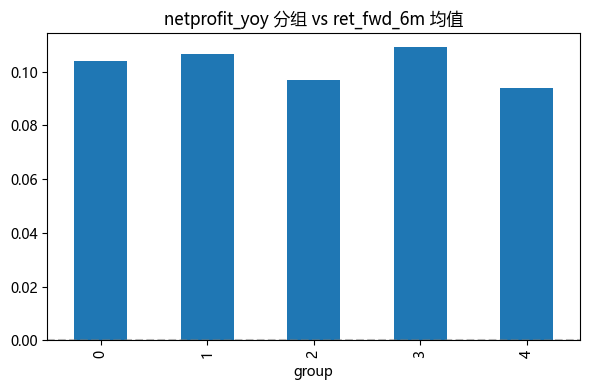

netprofit_yoy 分层（5组，持有 12m）未来收益均值:
group
0    0.159609
1    0.118528
2    0.075569
3    0.080663
4    0.071702
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: -0.0879


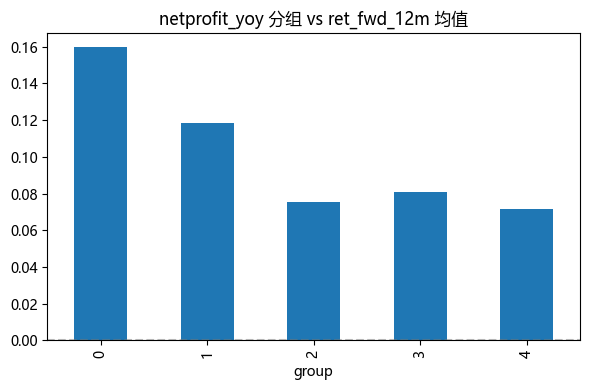

netprofit_yoy 分层（5组，持有 2y）未来收益均值:
group
0    0.186446
1    0.135498
2    0.070449
3    0.062419
4    0.038687
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.1478


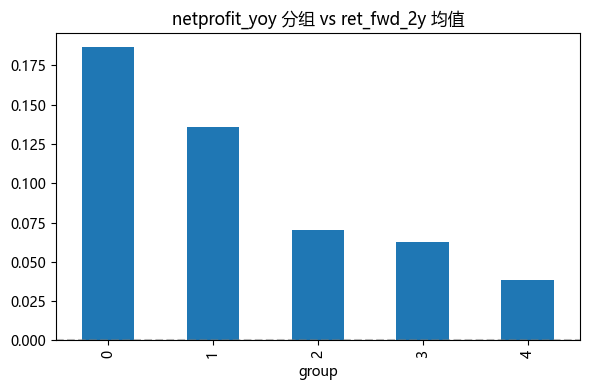

netprofit_yoy 分层（5组，持有 4y）未来收益均值:
group
0    0.085221
1    0.008352
2   -0.022064
3   -0.013884
4    0.014668
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.0706


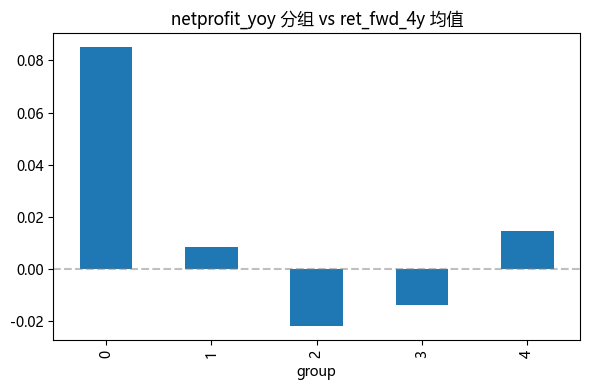

In [32]:
# 分层与分桶：支持多因子、多期限（原始因子）
if 'panel' not in globals() or panel.empty:
    raise ValueError('panel 为空')

panel_use = clean_panel if 'clean_panel' in globals() else panel
factors_for_layer = [f for f in ['roe', 'grossprofit_margin', 'netprofit_yoy'] if f in panel_use.columns]
horizons_for_layer = [h for h in ['1m', '3m', '6m', '12m', '2y', '4y'] if f'ret_fwd_{h}' in panel_use.columns]

if not factors_for_layer or not horizons_for_layer:
    print('缺少分层所需的因子或收益列')
else:
    for layer_factor in factors_for_layer:
        for h_key in horizons_for_layer:
            ret_col = f'ret_fwd_{h_key}'
            df_layer = panel_use[[layer_factor, ret_col]].dropna()
            if df_layer.empty:
                print(f'{layer_factor} {h_key}: 分层数据为空')
                continue
            df_layer = df_layer.copy()
            df_layer['group'] = pd.qcut(
                df_layer[layer_factor].rank(method='first'),
                q=5,
                labels=False,
                duplicates='drop'
            )
            grouped = df_layer.groupby('group')[ret_col].mean()
            top_bottom = grouped.iloc[-1] - grouped.iloc[0] if len(grouped) >= 2 else np.nan
            print(f'{layer_factor} 分层（5组，持有 {h_key}）未来收益均值:')
            print(grouped)
            print(f'top-bottom 价差: {top_bottom:.4f}' if pd.notna(top_bottom) else 'top-bottom 价差不可计算')
            grouped.plot(
                kind='bar',
                title=f'{layer_factor} 分组 vs {ret_col} 均值',
                figsize=(6, 4)
            )
            plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()


##### 4.4 原始分层（roe/grossprofit_margin/netprofit_yoy，1m-4y）

- 总体排序：多期限里“低因子”组大多优于“高因子”组，呈现反向/无序；top-bottom 价差多为负，小幅或中等。
- netprofit_yoy：中长端最明显反向（2y 价差约 -0.148，4y 约 -0.071），低增速组显著高于高增速组。
- roe：与之前一致，长端反向，短端无明显正向优势。
- grossprofit_margin：短端可能略正或平，长端趋弱甚至反向，未展现稳定正序。

## 4.4A 中性化分层（因子残差版）

- 使用 4.3A 的中性化因子（如 `roe_neu`）做分层，验证行业/市值中性后的排序表现。

- 方法：对中性化因子做全样本分位数分组（可改为日期内分组），计算未来收益均值与 top-bottom 价差，并绘制柱状图。

roe_neu 中性化分层（5组，持有 1m）未来收益均值:
group
0    0.124341
1    0.070698
2    0.040928
3    0.091559
4    0.141859
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: 0.0175


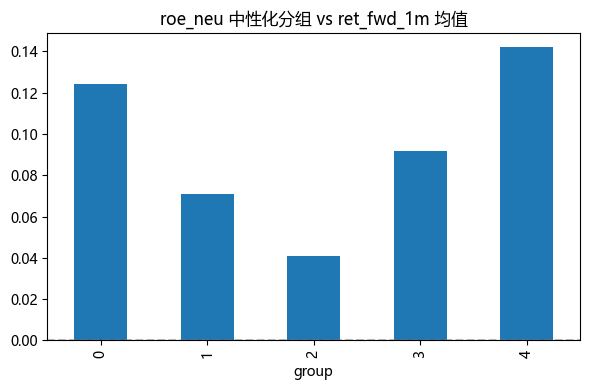

roe_neu 中性化分层（5组，持有 3m）未来收益均值:
group
0    0.107345
1    0.064842
2    0.037577
3    0.088633
4    0.123645
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: 0.0163


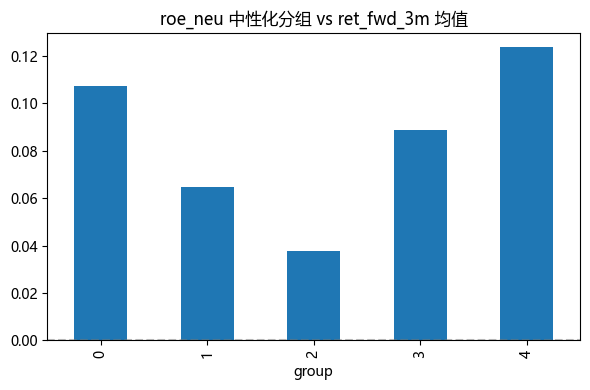

roe_neu 中性化分层（5组，持有 6m）未来收益均值:
group
0    0.110931
1    0.075687
2    0.060968
3    0.108647
4    0.126034
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: 0.0151


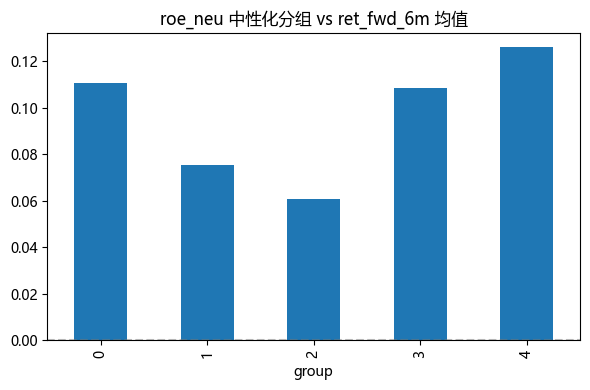

roe_neu 中性化分层（5组，持有 12m）未来收益均值:
group
0    0.085273
1    0.062823
2    0.066499
3    0.082265
4    0.071564
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: -0.0137


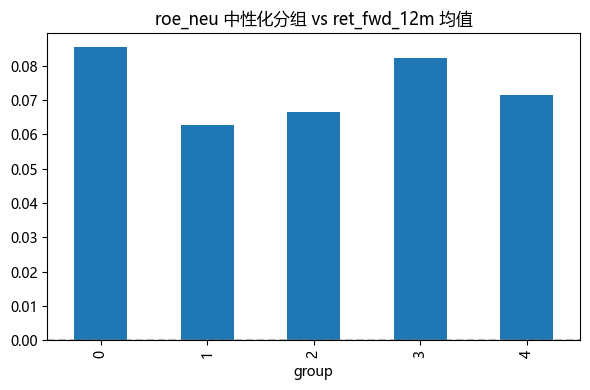

roe_neu 中性化分层（5组，持有 2y）未来收益均值:
group
0    0.086506
1    0.060356
2    0.065023
3    0.073687
4    0.047396
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.0391


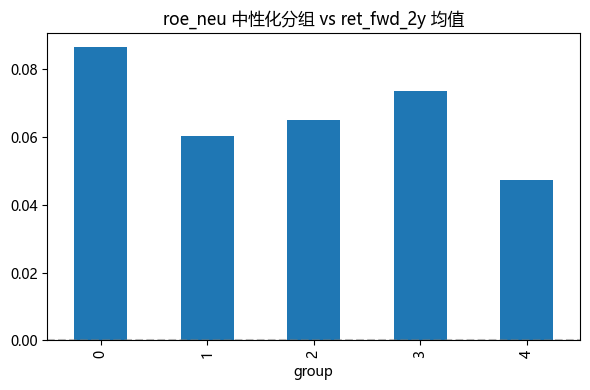

roe_neu 中性化分层（5组，持有 4y）未来收益均值:
group
0    0.018281
1   -0.001885
2   -0.018334
3    0.003450
4   -0.053204
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.0715


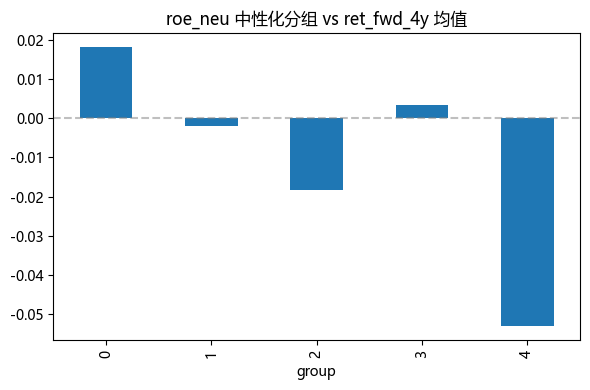

grossprofit_margin_neu 中性化分层（5组，持有 1m）未来收益均值:
group
0    0.085455
1    0.093169
2    0.062395
3    0.119888
4    0.102262
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: 0.0168


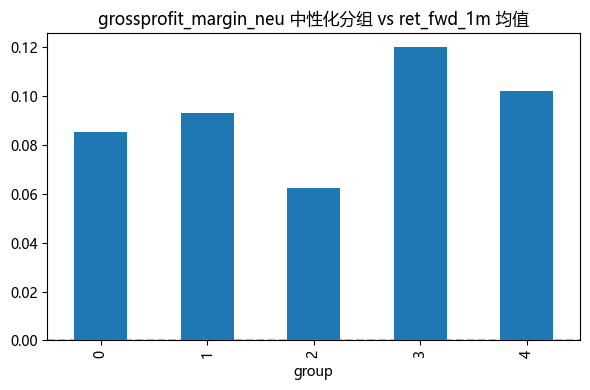

grossprofit_margin_neu 中性化分层（5组，持有 3m）未来收益均值:
group
0    0.081437
1    0.085250
2    0.053823
3    0.106398
4    0.089186
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: 0.0077


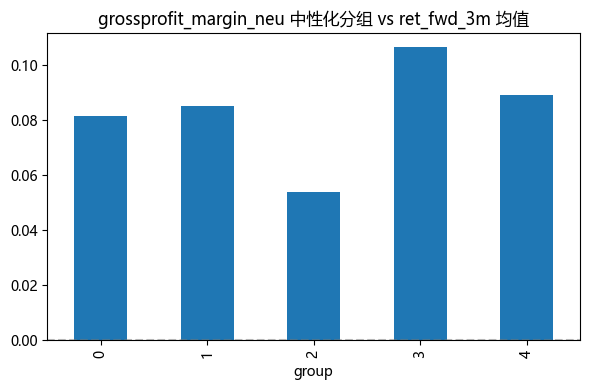

grossprofit_margin_neu 中性化分层（5组，持有 6m）未来收益均值:
group
0    0.099878
1    0.102206
2    0.068816
3    0.110135
4    0.097005
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: -0.0029


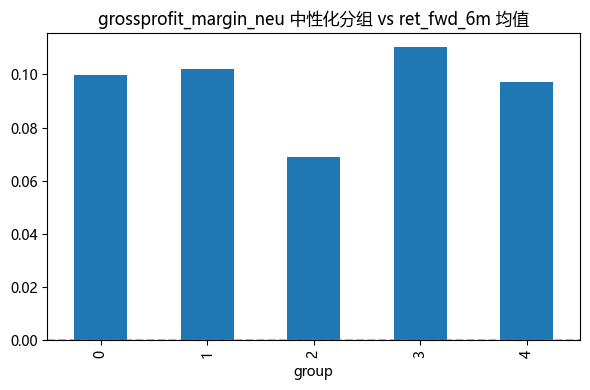

grossprofit_margin_neu 中性化分层（5组，持有 12m）未来收益均值:
group
0    0.087480
1    0.083376
2    0.074792
3    0.072628
4    0.054505
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: -0.0330


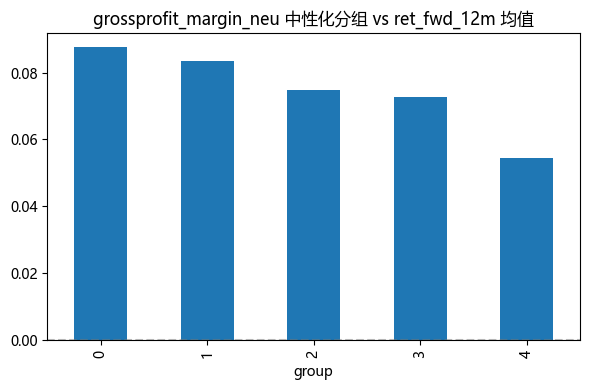

grossprofit_margin_neu 中性化分层（5组，持有 2y）未来收益均值:
group
0    0.095715
1    0.087406
2    0.077687
3    0.056630
4    0.024212
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.0715


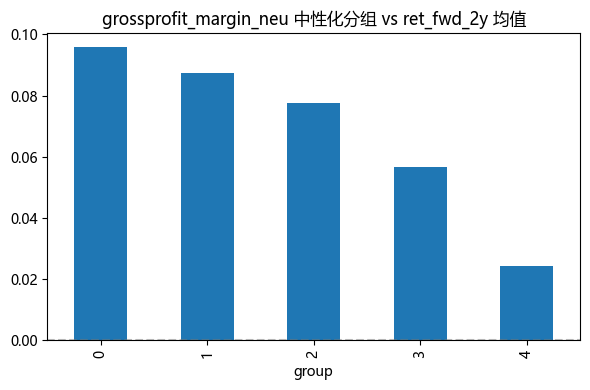

grossprofit_margin_neu 中性化分层（5组，持有 4y）未来收益均值:
group
0    0.024830
1    0.034618
2   -0.017205
3   -0.018975
4   -0.062211
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.0870


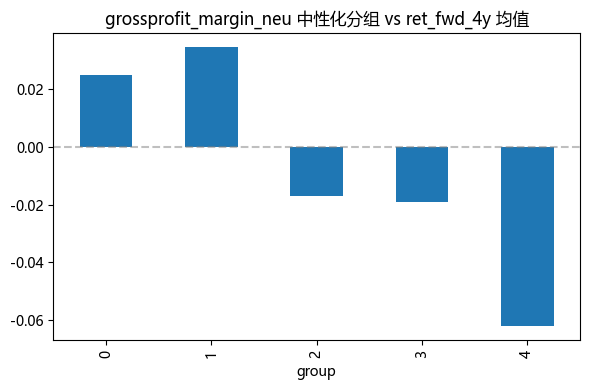

netprofit_yoy_neu 中性化分层（5组，持有 1m）未来收益均值:
group
0    0.098732
1    0.071196
2    0.051678
3    0.071686
4    0.080375
Name: ret_fwd_1m, dtype: float64
top-bottom 价差: -0.0184


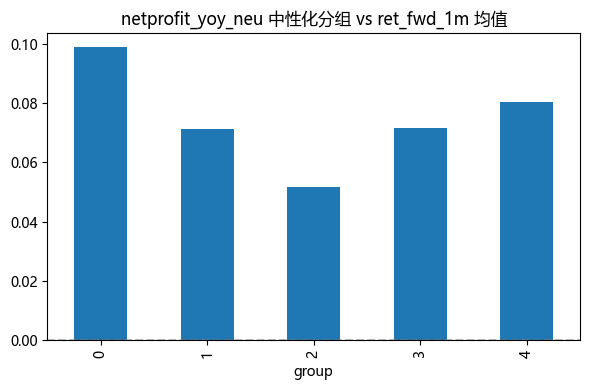

netprofit_yoy_neu 中性化分层（5组，持有 3m）未来收益均值:
group
0    0.090219
1    0.058528
2    0.037354
3    0.069056
4    0.085516
Name: ret_fwd_3m, dtype: float64
top-bottom 价差: -0.0047


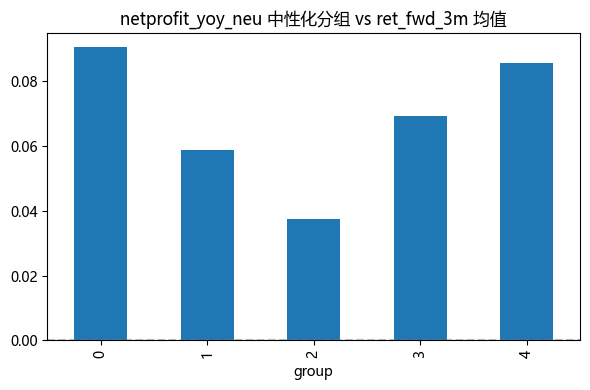

netprofit_yoy_neu 中性化分层（5组，持有 6m）未来收益均值:
group
0    0.102767
1    0.071260
2    0.058490
3    0.089776
4    0.106844
Name: ret_fwd_6m, dtype: float64
top-bottom 价差: 0.0041


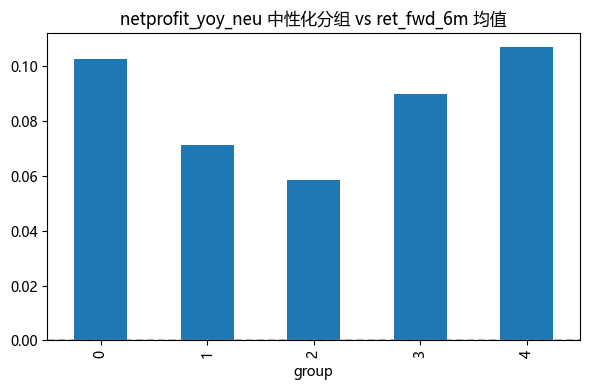

netprofit_yoy_neu 中性化分层（5组，持有 12m）未来收益均值:
group
0    0.081767
1    0.061092
2    0.064682
3    0.076390
4    0.088850
Name: ret_fwd_12m, dtype: float64
top-bottom 价差: 0.0071


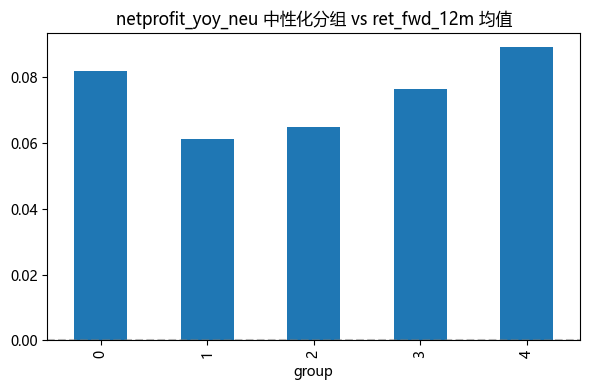

netprofit_yoy_neu 中性化分层（5组，持有 2y）未来收益均值:
group
0    0.086864
1    0.064574
2    0.068648
3    0.071717
4    0.080352
Name: ret_fwd_2y, dtype: float64
top-bottom 价差: -0.0065


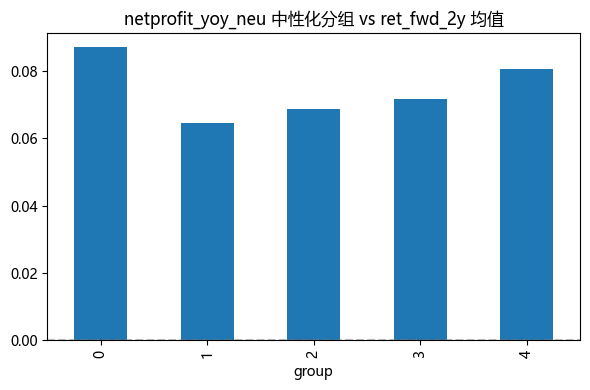

netprofit_yoy_neu 中性化分层（5组，持有 4y）未来收益均值:
group
0    0.029080
1   -0.003457
2   -0.026063
3   -0.019443
4   -0.013055
Name: ret_fwd_4y, dtype: float64
top-bottom 价差: -0.0421


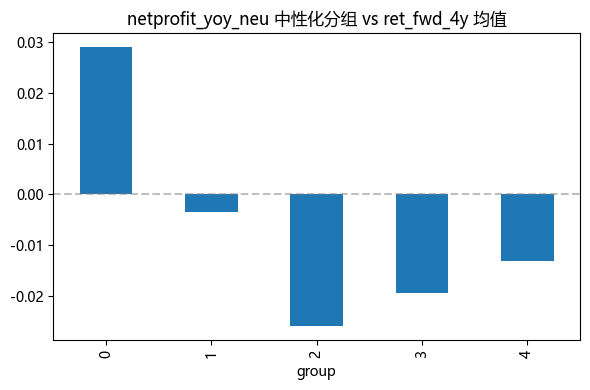

In [33]:
# 4.4A 中性化因子分层：支持多因子、多期限
if 'panel_neu' not in globals() or panel_neu.empty:
    raise ValueError('panel_neu 不存在，请先运行 4.3A')

panel_use = panel_neu.copy()
factors_for_layer = [c for c in ['roe_neu', 'grossprofit_margin_neu', 'netprofit_yoy_neu'] if c in panel_use.columns]
horizons_for_layer = [h for h in ['1m', '3m', '6m', '12m', '2y', '4y'] if f'ret_fwd_{h}' in panel_use.columns]

if not factors_for_layer or not horizons_for_layer:
    print('缺少分层所需的因子或收益列')
else:
    for layer_factor in factors_for_layer:
        for h_key in horizons_for_layer:
            ret_col = f'ret_fwd_{h_key}'
            df_layer = panel_use[[layer_factor, ret_col]].dropna()
            if df_layer.empty:
                print(f'{layer_factor} {h_key}: 分层数据为空')
                continue
            df_layer = df_layer.copy()
            df_layer['group'] = pd.qcut(
                df_layer[layer_factor].rank(method='first'),
                q=5,
                labels=False,
                duplicates='drop'
            )
            grouped = df_layer.groupby('group')[ret_col].mean()
            top_bottom = grouped.iloc[-1] - grouped.iloc[0] if len(grouped) >= 2 else np.nan
            print(f'{layer_factor} 中性化分层（5组，持有 {h_key}）未来收益均值:')
            print(grouped)
            print(f'top-bottom 价差: {top_bottom:.4f}' if pd.notna(top_bottom) else 'top-bottom 价差不可计算')
            grouped.plot(
                kind='bar',
                title=f'{layer_factor} 中性化分组 vs {ret_col} 均值',
                figsize=(6, 4)
            )
            plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()


##### 4.4A 中性化分层（roe_neu/grossprofit_margin_neu/netprofit_yoy_neu，1m-4y）

- 中性化后整体依然缺少可用排序；价差多数接近 0 或为反向，缺乏稳健正向信号。
- roe_neu：12m 价差 -0.0137（此前已观察），短端也无明显优势。
- netprofit_yoy_neu、grossprofit_margin_neu：与原始类似，长端偏反向或不显著，未提供稳定溢价。

## 4.5 时间稳定性

- 按年份滚动：IC 和回归系数时间序列

- 可选：牛熊分段对比

ROE 年度 IC 均值:
            1m        3m        6m       12m        2y        4y
year                                                            
2012 -0.026377  0.027865 -0.012589 -0.092352 -0.261956 -0.273906
2013 -0.028946 -0.027592 -0.094909 -0.244517 -0.258436 -0.170012
2014 -0.071901 -0.092780 -0.127217 -0.147366 -0.200557 -0.072500
2015  0.076946  0.025487 -0.007258 -0.063546 -0.031694 -0.034906
2016  0.141562  0.083653  0.086299  0.111607  0.112400  0.095188
2017  0.264938  0.261292  0.249257  0.147966  0.070195  0.031008
2018 -0.017381 -0.054799 -0.114072 -0.145783 -0.074069 -0.144684
2019  0.099074  0.077257  0.073783  0.061220 -0.029366 -0.189330
2020  0.019392  0.023691  0.007197 -0.075437 -0.157321 -0.205240
2021 -0.047060 -0.114991 -0.165390 -0.224650 -0.256811 -0.260310
2022 -0.098440 -0.152877 -0.208857 -0.240703 -0.211931       NaN
2023 -0.105609 -0.148055 -0.066110 -0.065988 -0.145048       NaN
2024 -0.097417 -0.111701 -0.181178 -0.199047       NaN       NaN
2025 -0.106

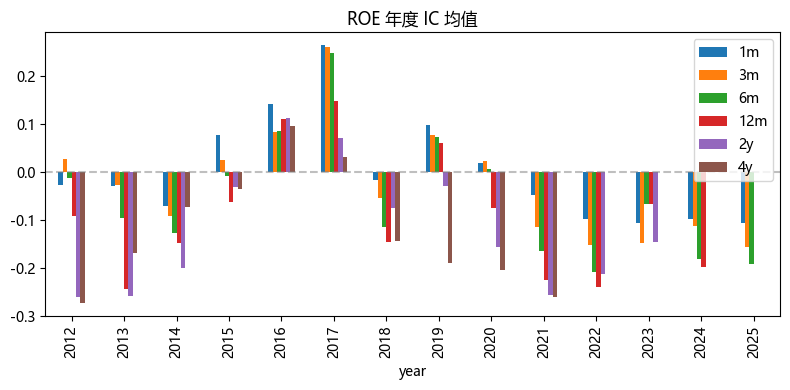

In [30]:
# 时间稳定性：按年份统计 IC 均值（示例用 ROE）
if 'roe' in ic_ts:
    ic_yearly = ic_ts['roe'].copy()
    ic_yearly['year'] = ic_yearly.index.year
    mean_by_year = ic_yearly.groupby('year').mean()
    print('ROE 年度 IC 均值:')
    print(mean_by_year)
    mean_by_year.plot(kind='bar', figsize=(8, 4))
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title('ROE 年度 IC 均值')
    plt.tight_layout()
    plt.show()
else:
    print('缺少 ROE IC 时间序列')

## 4.6 结果摘要

- 信号总体：ROE/毛利率/净利增速在样本内截面预测力弱，长端多为反向；短端亦不稳健。
- 分层（4.4）：原始因子 5 组排序多数反向或无序，top-bottom 常为负；netprofit_yoy 长端反向最明显。
- 中性化分层（4.4A）：行业+市值残差后仍无稳健正序，价差接近 0 或反向。
- 回归（4.3/4.3A/4.3B）：规模效应强且负；ROE 短端微弱正，12m+ 转负；毛利率、净利增速长端显著负。
- IC（4.2）：短端略正/近零，6m-4y 普遍为负，波动大。
- 结论：三因子不宜单独押注，尤其中长端；可考虑短端降权使用，或与估值/动量/其他质量因子做复合，必要时直接剔除。
- A股失效原因（假设）：
  - 高换手+题材偏好，资金偏好成长叙事而非静态盈利水平，导致高 ROE/高增速难转化为中长端超额。
  - 行业轮动快、景气切换频繁，单一财报截面难捕捉未来盈利周期，反而在周期反转期产生反向信号。
  - 披露滞后与质量异质，财报时点滞后市场预期，且部分指标易被季节性或会计选择扭曲。
  - 规模偏大时估值溢价稀缺，强烈的负向规模效应主导截面收益，淹没质量/增速信号。
  - 资金博弈与政策冲击占主导，基本面变量在高波动/事件驱动阶段权重下降，信号衰减。